---
title: PA 9.2
author: Marvin (Wenxiang) Li
format:
    html:
        toc: False
        code-fold: true
embed-resources: true
---


Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [ ]:
## library imports here
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer

In [ ]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [ ]:
ha

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1
...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0
269,57,0,0,140,241,1,123,0
270,45,1,3,110,264,1,132,0
271,68,1,0,144,193,1,141,0


In [ ]:
X = ha.drop("cp", axis = 1)
y = ha["cp"]

In [ ]:
import plotnine as p9

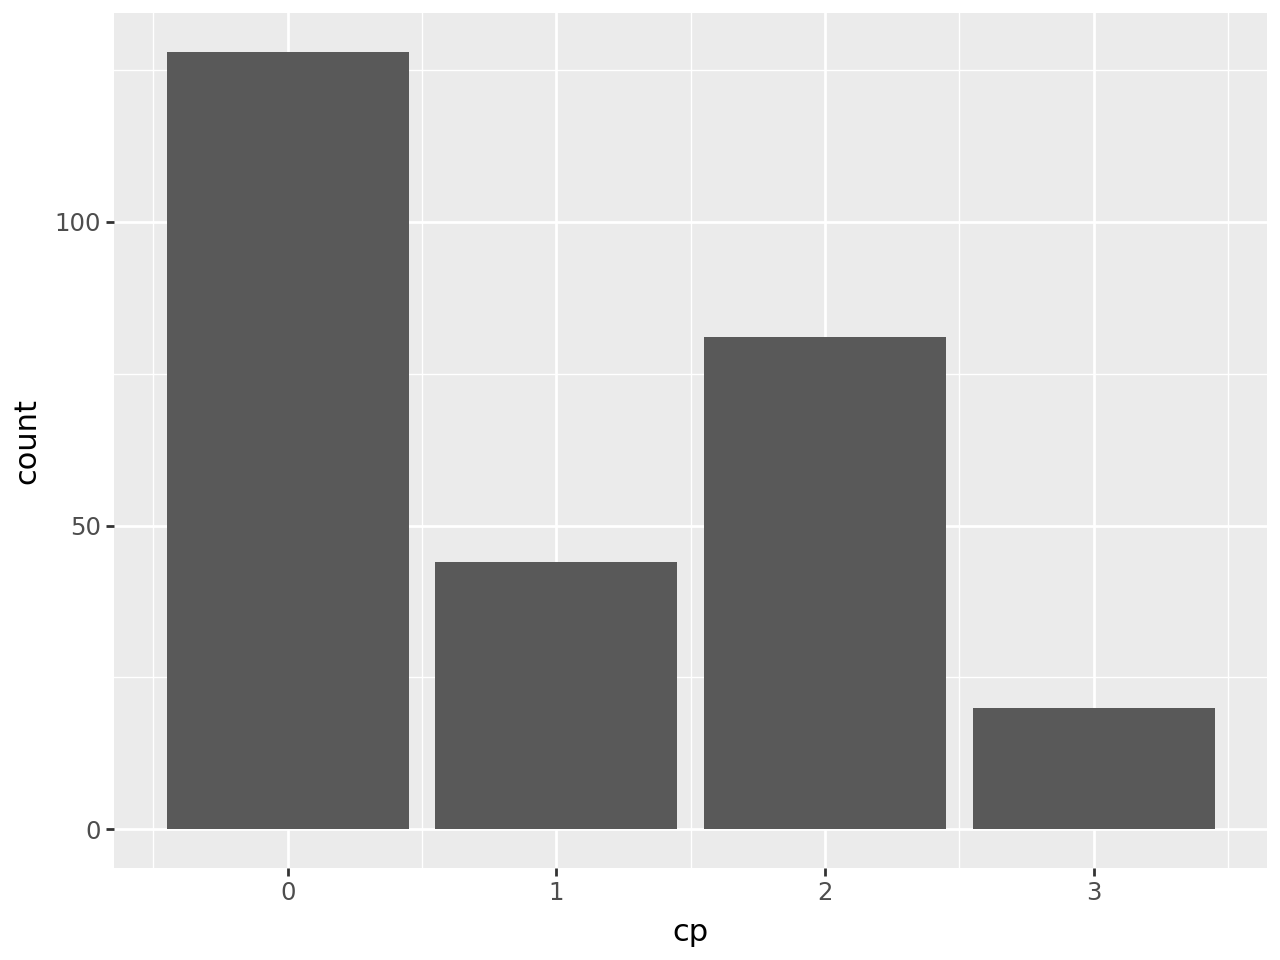

In [ ]:
p9.ggplot(ha) + p9.geom_bar(p9.aes(x = "cp"))

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [ ]:
def model_try(scaler, classifier, num, cat):
  ct = ColumnTransformer(
    [ ("num", StandardScaler(), num),
      ("cat", "passthrough", cat)
    ],
    remainder = "drop"
    )
  ct2 = ColumnTransformer(
    [ ("num", "passthrough", num),
      ("cat", "passthrough", cat)
    ],
    remainder = "drop"
    )
  if scaler == 'Yes':
    steps = [("preprocessing", ct), ('classifier', classifier)]
  if scaler == 'No':
    steps = [("preprocessing", ct2), ('classifier', classifier)]
  model = Pipeline(steps)
  return model

### 1. KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
num1 = ["age", "chol", "trtbps", "thalach"]
cat1 = ["sex", "output", "restecg"]
model_1 = model_try('Yes', KNeighborsClassifier(), num1, cat1)

In [ ]:
param_grid1 = {
    'classifier__n_neighbors': range(1, 21),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['manhattan', 'euclidean'],
}
search_1 = GridSearchCV(model_1, param_grid1, cv=5, scoring='roc_auc_ovr')
search_1_fitted = search_1.fit(X, y)

In [ ]:
result_1 = pd.DataFrame(data = {"metric":  search_1.cv_results_['param_classifier__metric'],
                            "n_neighbors": search_1.cv_results_['param_classifier__n_neighbors'],
                            "weights": search_1.cv_results_['param_classifier__weights'],
                            "mean_roc_auc": search_1.cv_results_['mean_test_score']}
                            ).sort_values(by = "mean_roc_auc", ascending = False)
result_1.head(3)

,metric,n_neighbors,weights,mean_roc_auc
38,manhattan,20,uniform,0.662136
39,manhattan,20,distance,0.658439
34,manhattan,18,uniform,0.658104


### 2. Tree

In [ ]:
num3 = ["age", "trtbps", "thalach"]
cat3 = ['sex','output']
model_3 = model_try("No", DecisionTreeClassifier(random_state= 42), num3, cat3)

In [ ]:
param_grid3 = {
    'classifier__min_impurity_decrease': [0.001, 0.01, 0.05, 0.1],
    'classifier__max_depth': [2, 5, 10, 15, None],
    'classifier__max_features': [None, 'sqrt', 3, 4],
    'classifier__ccp_alpha': [0, 0.001, 0.01, 0.1, 0.2],
}
search_3 = GridSearchCV(model_3, param_grid3, cv=5, scoring='roc_auc')
search_3_fitted = search_3.fit(X, y)

Predicted,3,2,1,0
Actual,,,,
3,0,11,1,8
2,0,33,12,36
1,0,23,9,12
0,0,28,2,98


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?